In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!ls

drive  sample_data


In [3]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 5.1 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=db86f72223ed92e30143c64aaebd284a64b72710b4609e367b0966d714919c1e
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 567 kB/s 
     |████████████████████████████████| 145 kB 5.0 MB/s 
     |████████████████████████████████| 74 kB 4.3 MB/s 
     |████████████████████████████████| 50 kB 7.5 MB/s 
     |████████████████████████████████| 130 kB 33.1 MB/s 
     |████████████████████████████████| 749 kB 72.1 MB/s 
     |████████████████████████████████

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [2]:
%cd /content/drive/MyDrive/Computer Vision Projects/Object Detection/Oxford-IIIT-Pet/annotations

/content/drive/MyDrive/Computer Vision Projects/Object Detection/Oxford-IIIT-Pet/annotations


In [3]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("customtrain10", {}, "./output.json", "./train")

In [4]:
sample_metadata = MetadataCatalog.get("customtrain10")
dataset_dicts = DatasetCatalog.get("customtrain10")

WARNING [04/09 06:06:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/09 06:06:07 d2.data.datasets.coco]: Loaded 3686 images in COCO format from ./output.json


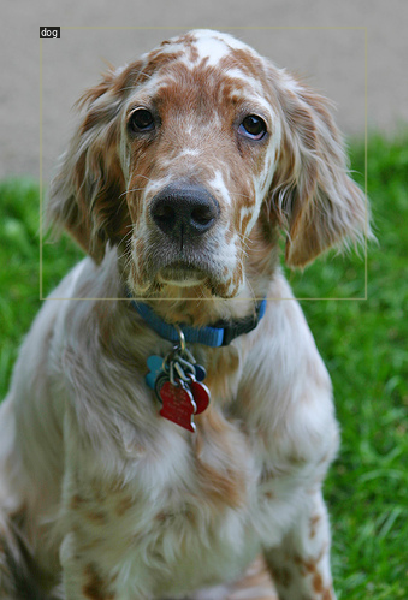

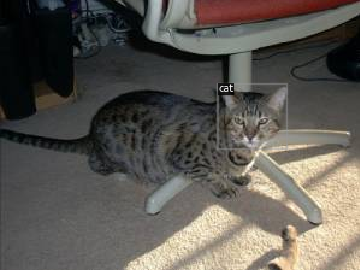

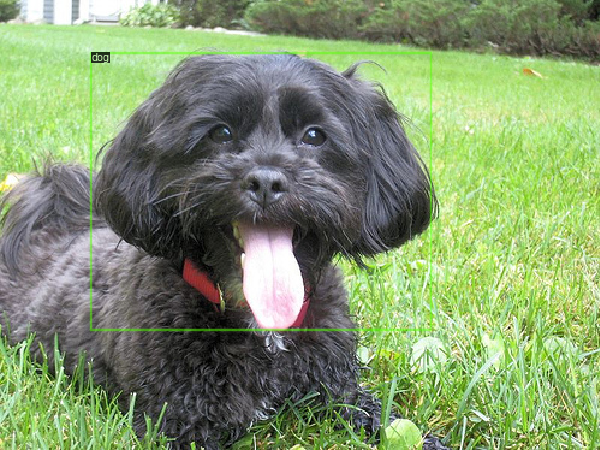

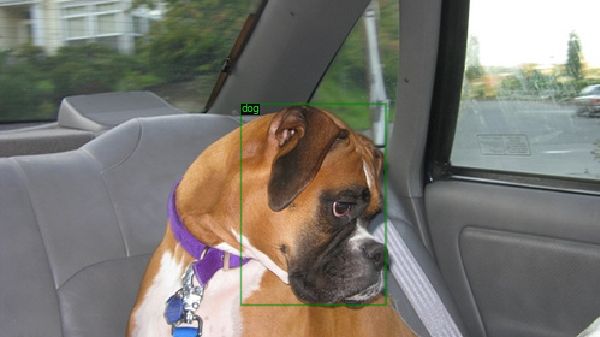

In [5]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=1.2)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [22]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("customtrain10",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 12000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()

[04/09 06:43:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[04/09 06:43:23 d2.utils.events]:  eta: 0:23:06  iter: 8019  total_loss: 0.145  loss_cls: 0.01753  loss_box_reg: 0.1189  loss_rpn_cls: 0.0002088  loss_rpn_loc: 0.002022  time: 0.3542  data_time: 0.0172  lr: 0.0025  max_mem: 4018M
[04/09 06:43:30 d2.utils.events]:  eta: 0:24:30  iter: 8039  total_loss: 0.1401  loss_cls: 0.02552  loss_box_reg: 0.1083  loss_rpn_cls: 0.0002159  loss_rpn_loc: 0.001803  time: 0.3662  data_time: 0.0112  lr: 0.0025  max_mem: 4018M
[04/09 06:43:38 d2.utils.events]:  eta: 0:24:23  iter: 8059  total_loss: 0.1701  loss_cls: 0.02543  loss_box_reg: 0.1294  loss_rpn_cls: 0.0001681  loss_rpn_loc: 0.001699  time: 0.3684  data_time: 0.0073  lr: 0.0025  max_mem: 4018M
[04/09 06:43:45 d2.utils.events]:  eta: 0:23:53  iter: 8079  total_loss: 0.1437  loss_cls: 0.02221  loss_box_reg: 0.117  loss_rpn_cls: 0.0001676  loss_rpn_loc: 0.001925  time: 0.3650  data_time: 0.0078  lr: 0.0025  max_mem: 4018M
[04/09 06:43:52 d2.utils.events]:  eta: 0:23:38  iter: 8099  total_loss: 0.145

In [23]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("customtrain10", )
predictor = DefaultPredictor(cfg)

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


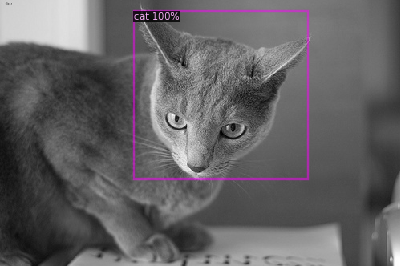

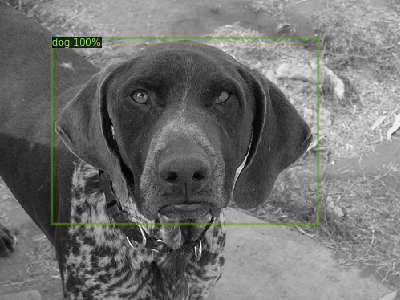

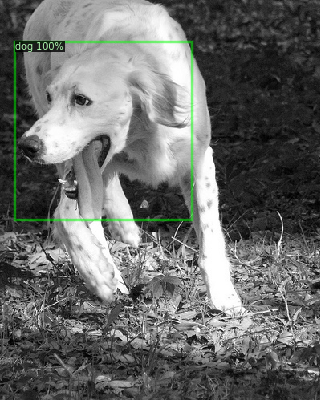

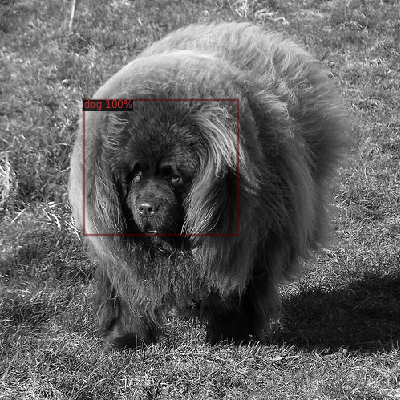

In [25]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [26]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()

In [27]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("customtrain10")
val_loader = build_detection_test_loader(cfg, "customtrain10")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [04/09 07:09:11 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/09 07:09:11 d2.data.datasets.coco]: Loaded 3686 images in COCO format from ./output.json
[04/09 07:09:11 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/09 07:09:11 d2.data.common]: Serializing 3686 elements to byte tensors and concatenating them all ...
[04/09 07:09:11 d2.data.common]: Serialized dataset takes 0.84 MiB
[04/09 07:09:11 d2.evaluation.evaluator]: Start inference on 3686 batches


/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


[04/09 07:09:12 d2.evaluation.evaluator]: Inference done 11/3686. Dataloading: 0.0014 s/iter. Inference: 0.0824 s/iter. Eval: 0.0002 s/iter. Total: 0.0840 s/iter. ETA=0:05:08
[04/09 07:09:17 d2.evaluation.evaluator]: Inference done 70/3686. Dataloading: 0.0017 s/iter. Inference: 0.0827 s/iter. Eval: 0.0002 s/iter. Total: 0.0847 s/iter. ETA=0:05:06
[04/09 07:09:22 d2.evaluation.evaluator]: Inference done 130/3686. Dataloading: 0.0018 s/iter. Inference: 0.0821 s/iter. Eval: 0.0002 s/iter. Total: 0.0841 s/iter. ETA=0:04:59
[04/09 07:09:27 d2.evaluation.evaluator]: Inference done 193/3686. Dataloading: 0.0016 s/iter. Inference: 0.0811 s/iter. Eval: 0.0002 s/iter. Total: 0.0830 s/iter. ETA=0:04:49
[04/09 07:09:33 d2.evaluation.evaluator]: Inference done 252/3686. Dataloading: 0.0016 s/iter. Inference: 0.0818 s/iter. Eval: 0.0002 s/iter. Total: 0.0836 s/iter. ETA=0:04:47
[04/09 07:09:38 d2.evaluation.evaluator]: Inference done 310/3686. Dataloading: 0.0016 s/iter. Inference: 0.0824 s/iter. E

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


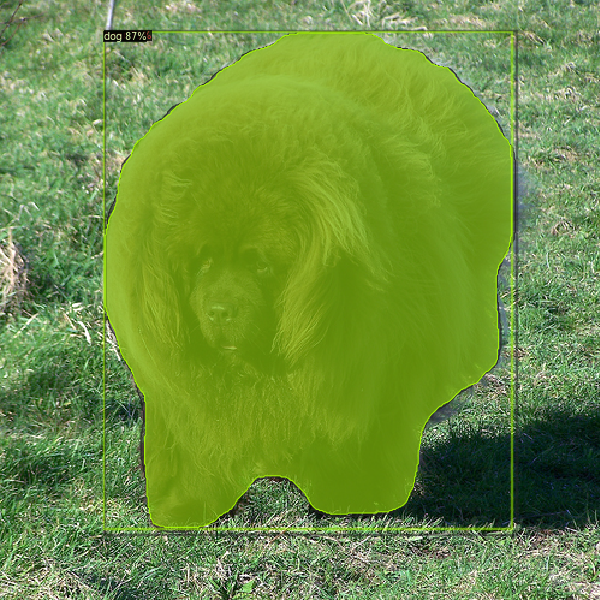

In [38]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


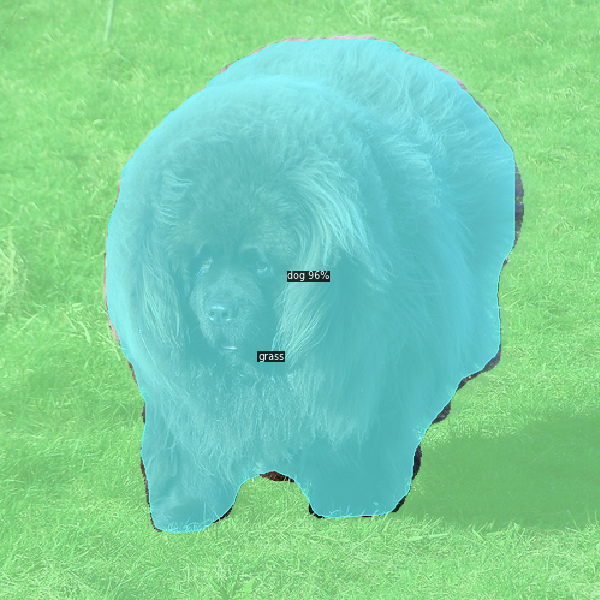

In [39]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

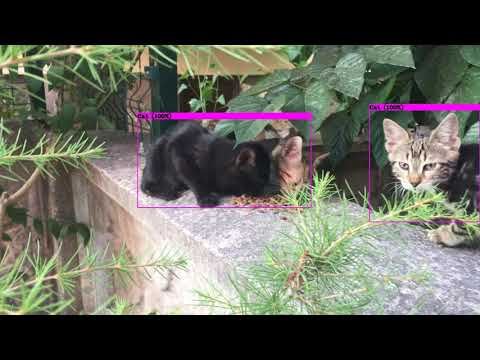

In [59]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("UXjQA5-xqbc", width=500)
display(video)



In [62]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!youtube-dl https://www.youtube.com/watch?v=UXjQA5-xqbc -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:16 -c:v copy video-clip4.mp4

[youtube] UXjQA5-xqbc: Downloading webpage
[youtube] UXjQA5-xqbc: Downloading MPD manifest
[download] Destination: video.mp4
[download] 100% of 4.47MiB in 01:01
ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libt

In [63]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes) with the "demo.py" tool we provided in the repo.
!git clone https://github.com/facebookresearch/detectron2
# Note: this is currently BROKEN due to missing codec. See https://github.com/facebookresearch/detectron2/issues/2901 for workaround.
%run detectron2/demo/demo.py --config-file detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input video-clip4.mp4 --confidence-threshold 0.6 --output video-output5.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

fatal: destination path 'detectron2' already exists and is not an empty directory.
[04/09 08:16:01 detectron2]: Arguments: Namespace(confidence_threshold=0.6, config_file='detectron2/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml', input=None, opts=['MODEL.WEIGHTS', 'detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl'], output='video-output5.mkv', video_input='video-clip4.mp4', webcam=False)
[04/09 08:16:03 fvcore.common.checkpoint]: [Checkpointer] Loading from detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...
[04/09 08:16:03 fvcore.common.checkpoint]: Reading a file from 'Detectron2 Model Zoo'


  0%|          | 0/465 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
100%|██████████| 465/465 [06:16<00:00,  1.24it/s]


In [67]:
# Download the results
from google.colab import files
files.download('video-output6.mkv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
# !git clone https://github.com/vandeveldemaarten/tempdetector2video.git
# Video("./tempdetector2video/video-output2.mkv")